# Accelerated Failure Time

* The canonical example of Accelerated Failure Time models, shared by Kleinbaum & Klein in Survival Analysis: A Self-Learning Text, is the lifespan of dogs. It is commonly accepted that dogs age 7x faster than humans. They go through the same lifestages that we do, just faster.

* In contrast to Kaplan-Meier and Cox Proportional Hazards, Accelerated Failure Time is a parametric model. This means that the outcome variable is assumed to follow a specified distribution. Parametric models are typically less 'flexible' than non-parametric and semi-parametric models but can be a good choice when you're comfortable with specifying the distribution of the outcome variable.

* Similar to Cox Proportional Hazards, the Accelerated Failure Time model has underlying assumptions to be aware of. These assumptions are covered below.

## The Accelerated Failure Time Model Equation

* Using the Accelerated Failure Time equation below, if we were to define group A as humans and group B as dogs, then the acceleration factor would be 7. Similarly, if we define group A as dogs and group B as humans, then the acceleration factor would be 1/7.

* The specification for lambda, which represents the accelerated failure rate, is intentionally generalized here. In practice, the survival function for the accelerated failure rate includes one or more parameters. For example, the specification when using log-logistic accelerated failure time is: 1/(1+lambda x t ^ p).

* The full specification of the accelerated failure rate is most relevant when using log-log plots to verify whether the accelerated failure time assumptions have been violated. This is covered in further detail below.

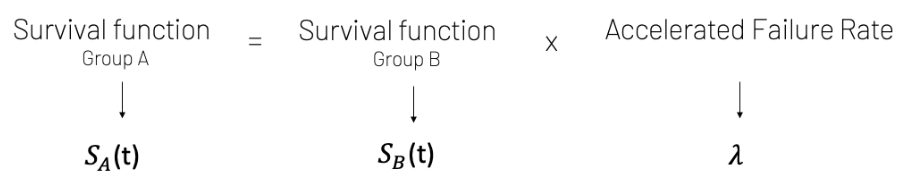

#### Setup

In [ ]:
! pip install lifelines

In [9]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
from lifelines import WeibullAFTFitter,LogNormalAFTFitter,LogLogisticAFTFitter
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

In [ ]:
! wget https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

In [4]:
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

# To keep the analysis focused, let's just filter to internet subscribers with a month-to-month contract
df = df[df['Contract'] == 'Month-to-month']

df = df[df['InternetService'] != 'No']

# Convert Churn column to a boolean
df['Churn'] = df['Churn'].replace(to_replace=['No', 'Yes'], value=[0, 1])

print('Data Shape : ', df.shape)
df.head()

Data Shape :  (3351, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0


### One-Hot Encode the Categorical Variables

* As is the case when using the Lifelines library to fit a Cox Proportional Hazards model, you must one-hot encode your categorical columns when using an Accelerated Failure Time model. We have hand-selected 8 variables to use for this notebook.

* After one-hot encoding the variables, we then created a new dataframe consisting of only the columns we need in order to fit the model.

* When creating the dataframe that you will use to fit the model, it is important that you drop one column for each one-hot encoded variable. For example, we included dependents_yes and dropped dependents_no. If you neglect to do this, you will likely receive an error when fitting the model that states that there are multi-collinearity issues with your data. This means that certain columns are highly correlated. For example, if you know that dependents_yes = 1 then you in turn know that dependents_no = 0.

* You can take one of two approaches when dropping variables. When using Pandas' get_dummies() function, you can simply set drop_first = True. An alternative approach, which is the one taken here, is to hand-select which variables to drop. In this notebook, we dropped the value that had a Kaplan-Meier survival probability curve most similar to the population. While this is by no means necessary, it affords an intuitive interpretation as the baseline closely resembles the population.

In [5]:
encode_cols = ['Partner','MultipleLines','InternetService','OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','PaymentMethod']
 
encoded_pd = pd.get_dummies(df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
encoded_pd.head()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,StreamingTV,StreamingMovies,Contract,PaperlessBilling,...,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,Female,0,No,1,No,No,No,Month-to-month,Yes,...,0,1,1,0,1,0,0,0,1,0
2,3668-QPYBK,Male,0,No,2,Yes,No,No,Month-to-month,Yes,...,0,1,1,0,1,0,0,0,0,1
4,9237-HQITU,Female,0,No,2,Yes,No,No,Month-to-month,Yes,...,1,0,1,0,1,0,0,0,1,0
5,9305-CDSKC,Female,0,No,8,Yes,Yes,Yes,Month-to-month,Yes,...,1,0,0,1,1,0,0,0,1,0
6,1452-KIOVK,Male,0,Yes,22,Yes,Yes,No,Month-to-month,Yes,...,0,1,1,0,1,0,0,1,0,0


In [7]:
survival_pd = encoded_pd[['Churn','tenure','Partner_Yes', 'MultipleLines_Yes', \
                          'InternetService_DSL','OnlineSecurity_Yes','OnlineBackup_Yes','DeviceProtection_Yes','TechSupport_Yes',\
                          'PaymentMethod_Bank transfer (automatic)','PaymentMethod_Credit card (automatic)']]

### Fit the Accelerated Failure Time Model

Similar to Kaplan-Meier and Cox Proportional Hazards, the first step when using the Lifelines library for Accelerated Failure Time is to fit the model.

* In this notebook, the type of distribution that we have specified for the outcome variable is log-logistic. This is reflected by the use of LogLogisticAFTFitter when fitting the model. Other options that are available through Lifelines include: WeibullAFTFitter, LogNormalAFTFitter. After we fit the model and assess the results, we will assess whether LogLogistic is the appropriate type of distribution to specify for this dataset.

* We provided three parameters to the fitted model:

  1. `suvival_pd`: the dataframe used to fit the model
  2. `Tenure`: the duration that a customer has been with the company (if still a subscriber) or was with the company prior to churning.
  3. `Churn`: a Boolean indicating whether the customer is still a subscriber or not.

In [10]:
aft = LogLogisticAFTFitter()
aft.fit(survival_pd, duration_col='tenure', event_col='Churn')

<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>

In [11]:
# Note: the output is exponentiated because it is initially in log-odds
print("Median Survival Time:{:.2f}".format(np.exp(aft.median_survival_time_)))

Median Survival Time:135.51


### Assess the Results of the Fitted Model

There are three key questions to ask when initially assessing the model:

1. <u>Is each covariate statistically significant?</u>
In the column labeled p below, it can be seen that the p-value for each column is below < 0.005. Therefore, each of the columns is statistically significant and safe to include.
Similar to other forms of regression, in the event that a variable is not statisitically significant, you can drop that column from your analysis or recategorize the corresponding values.

2. <u>How confident are we in the coefficient estimates?</u>
Upper and lower bounds for each coefficient and exp(coefficient) are provided in the model summary below (e.g. exp(coef) lower 95%, exp(coef) upper 95%).
Shown below the model summary, these bounds can also be viewed visually. Although it's not seen here, note that when viewing the bounds in this way, a variable can be deemed as not signficant when it's corresponding box-and-whisker plot crosses the value 1.

3. <u>What is the effect of each covariate on the hazard ratio?</u>
Using internetService_DSL as an example, it's shown below that coef = 0.38 and exp(coef) = 1.47. Referring back to the Accelerated Failure Time equation, this means that a customer's time-until-churn is accelerated by a factor of 1.47 when they have Fiber Optic as their internet service. Note that Fiber Optic is the baseline value and corresponds to Group A in the equation shared above.



Note that this output also includes several metrics that can be used when comparing models:
  1. Concordance
  2. AIC
  3. Log-likelihood Ratio

In [12]:
aft.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 3351 total observations, 1795 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 3351
number of events observed = 1556
           log-likelihood = -6838.36
         time fit was run = 2022-08-05 19:06:11 UTC

---
                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                                       
alpha_ DeviceProtection_Yes                      0.48       1.62       0.07             0.35             0.62                 1.41                 1.86
       InternetService_DSL                       0.38       1.47       0.08             0.23             0.53                 1.26                 1.71
       MultipleLines_Yes                         0.66       1.94       0.07             0.53             0.80                 1.70                 2.22
       OnlineBackup_Yes                          0.81       2.25       0.07             0.68             0.95                 1.97                 2.59
       OnlineSecurity_Yes                        0.86       2.37       0.09             0.69             1.03                 2.00                 2.80
       Partner_Yes                               0.68       1.97       0.07             0.55             0.81                 1.73                 2.24
       PaymentMethod_Bank transfer (automatic)   0.74       2.10       0.09             0.56             0.92                 1.75                 2.51
       PaymentMethod_Credit card (automatic)     0.80       2.22       0.10             0.61             0.99                 1.84                 2.68
       TechSupport_Yes                           0.69       1.99       0.09             0.52             0.86                 1.68                 2.36
       Intercept                                 1.59       4.91       0.07             1.46             1.72                 4.32                 5.58
beta_  Intercept                                 0.12       1.13       0.02             0.08             0.16                 1.08                 1.17

                                                 cmp to     z      p   -log2(p)
param  covariate                                                               
alpha_ DeviceProtection_Yes                        0.00  6.88 <0.005      37.25
       InternetService_DSL                         0.00  4.98 <0.005      20.59
       MultipleLines_Yes                           0.00  9.64 <0.005      70.70
       OnlineBackup_Yes                            0.00 11.63 <0.005     101.50
       OnlineSecurity_Yes                          0.00 10.12 <0.005      77.60
       Partner_Yes                                 0.00 10.21 <0.005      78.93
       PaymentMethod_Bank transfer (automatic)     0.00  8.05 <0.005      50.07
       PaymentMethod_Credit card (automatic)       0.00  8.36 <0.005      53.81
       TechSupport_Yes                             0.00  7.90 <0.005      48.37
       Intercept                                   0.00 24.47 <0.005     436.88
beta_  Intercept                                   0.00  5.71 <0.005      26.42
---
Concordance = 0.73
AIC = 13698.72
log-likelihood ratio test = 877.49 on 9 df
-log2(p) of ll-ratio test = 605.78

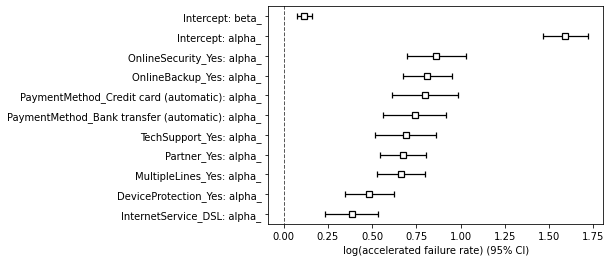

In [14]:
aft.plot();

### Verify if the Model Adheres to Assumptions
* As we saw with Cox Proportional Hazards, log-log plots are very helpful for assessing whether a model violates assumptions.

  * For Cox Proportional Hazards, log-log plots were created with log(time) on the x-axis and the log-log of the survival function on the y-axis.

  * For Accelerated Failure Time, the formula that is used for the y-axis is dependent upon the type of distribution specified for the outcome variable. Since we are using log-logistic here, the formula for the y-axis is: log(1 - survival_function) / survival_function.

* There are two underlying assumptions to assess when using an Accelerated Failure Time model:

  * Does the model adhere to the Proportional Odds assumption? - the answer is yes when lines in the plot are parallel.

  * Is the specified distribution appropriate for this model? - the answer is yes when the lines are straight.

* How does our model fare?

* For the most part, the lines in each of the plots are relatively straight. There is some deviation but not bad overall. This implies that selecting log-logistic as the specified distribution is a reasonable choice.

* For the most part, the lines in each of the plots are not parallel. This implies that Accelerated Failure Time is not appropriate for the specified model.

In [15]:
# Fit the Kaplan-Meier model
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
 
T = df['tenure'] #duration
C = df['Churn'].astype(float) #event observed
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3351 total observations, 1795 right-censored observations>

In [17]:
# Utility function for plotting
import matplotlib.pyplot as plt
 
def plot_km_logOdds(col):
  ax = plt.subplot(111)
  for r in df[col].unique():
    ix = df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    sf = kmf.survival_function_
    sf['failureOdds'] = (np.log(1-sf))/sf
    sf['logTime'] = np.log(sf.index)
    plt.plot(sf['logTime'],sf['failureOdds'])

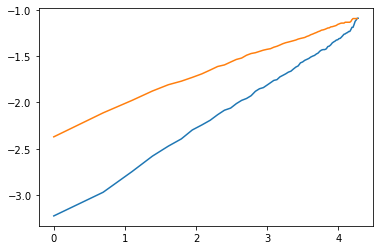

In [19]:
plot_km_logOdds('Partner')

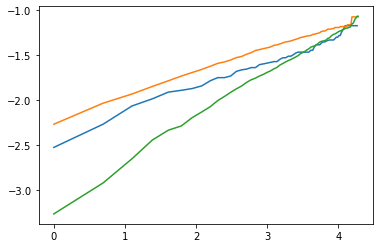

In [20]:
plot_km_logOdds('MultipleLines')

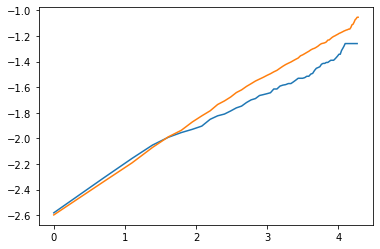

In [21]:
plot_km_logOdds('InternetService')

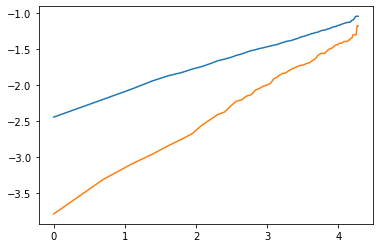

In [22]:
plot_km_logOdds('OnlineSecurity')

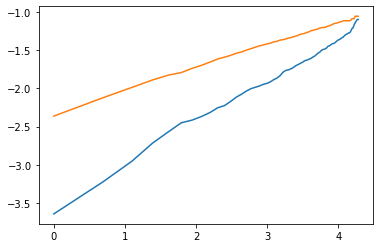

In [23]:
plot_km_logOdds('OnlineBackup')

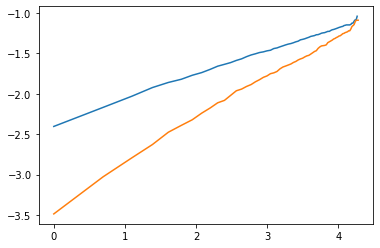

In [24]:
plot_km_logOdds('DeviceProtection')

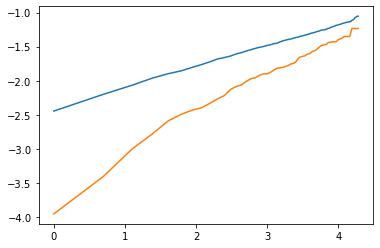

In [25]:
plot_km_logOdds('TechSupport')

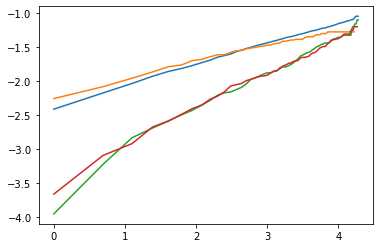

In [26]:
plot_km_logOdds('PaymentMethod')

### Summary

* Cox Proportional Hazards is by far the most popular method used for Time-to-Event (or Survival) Analysis. A big part of why this is the case is that as a semi-parametric model, you are not required to specify the form of your outcome variable. Compounding this benefit, this model tends to perform quite well, and as discussed in the previous notebook, there are a number of techniques available for further improvement.

* While Cox Proportional Hazards is often a good choice, it's beneficial to know that other options do exist. In this notebook, we reviewed a fully parametric model referred to as Accelerated Failure Time.

* In practice, if your goal is inference, you should select the model that best adheres to the underlying assumptions. If you goal is prediction, you should select the model that performs best with respect to your chosen evaluation metric. For this specific dataset, it would be advised to further explore options 2, 3, and 4 shared in the closing thoughts section of the Cox Proportional Hazards notebook.